In [47]:
import rasterio
import numpy as np
import random
import math
import itertools
import os
import sys
import resnet as rs
import importlib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import classifier_utilities as cu
import new_classifier_utilities as nw


In [50]:
importlib.reload(cu)

<module 'classifier_utilities' from '/host/Desktop/cnn_dev/florence_mapping/classifier_utilities.py'>

In [30]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [3]:
landsat_datasets, sentinel_datasets, dem_datasets, label_dataset = cu.load_data()

In [33]:
batch_size = 25
epochs = 200
num_classes = len(cu.indexed_dictionary)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_bands,img_cols,img_rows)
print(input_shape)

(10, 64, 64)


In [18]:
pixels = nw.gen_balanced_pixel_locations(landsat_datasets[1:2], 80000, label_dataset=label_dataset)


100%|██████████| 1/1 [00:53<00:00, 53.65s/it]

In [34]:
print(len(pixels))

75000


In [21]:
clear_pixels = cu.delete_black_tiles(landsat_datasets[1:2], tile_side, pixels)

In [35]:
print(len(clear_pixels))

34673


In [ ]:
buckets = cu.pixel_balance(pixels, landsat_datasets[1:2], label_dataset)
for i in range(len(cu.indexed_dictionary)):
    print("{}:{}".format(cu.indexed_dictionary[i], buckets[i]))

In [23]:
train_px, val_px, test_px = cu.train_val_test_split(pixels, 0.7, 0.8)

In [36]:
print(len(train_px))
print(len(val_px))
print(len(test_px))

52500
18000
8100


In [37]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model

In [26]:
def make_model(in_shape):
    input_tensor = Input(shape = in_shape)
    
    conv_1 = SeparableConv2D(64, kernel_size=(3,3), activation='elu') (input_tensor)
    norm_1 = BatchNormalization() (conv_1)
    dropout_1 = Dropout(rate=0.5) (norm_1)
    pool_1 = MaxPooling2D() (dropout_1)
    
    
    conv_2 = SeparableConv2D(64, kernel_size=(3,3), activation='elu') (pool_1)
    norm_2 = BatchNormalization() (conv_2)
    pool_2 = MaxPooling2D() (norm_2)
    
    conv_3 = SeparableConv2D(64, kernel_size=(3,3), activation='elu') (pool_2)
    norm_3 = BatchNormalization() (conv_3)
    dropout_3 = Dropout(rate=0.5) (norm_3)
    pool_3 = MaxPooling2D() (dropout_3)

    
    flatten = Flatten() (pool_3)
    dense = Dense(128, activation='elu') (flatten)
    output = Dense(num_classes,activation='softmax') (dense)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [38]:
model = rs.ResnetBuilder.build_resnet_18(input_shape,num_classes)
#model = make_model(input_shape)

In [40]:
opt = Adam(lr= 0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.fit_generator(generator=nw.tile_generator(landsat_datasets[1:2], sentinel_datasets[1:2], dem_datasets[1:2], label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=nw.tile_generator(landsat_datasets[1:2], sentinel_datasets[1:2], dem_datasets[1:2], label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px)// batch_size)

Epoch 1/200
2100/2100 [==============================] - 352s 168ms/step - loss: 2.6392 - acc: 0.1466 - val_loss: 2.8548 - val_acc: 0.0635
Epoch 2/200
2100/2100 [==============================] - 380s 181ms/step - loss: 2.4229 - acc: 0.1666 - val_loss: 2.9948 - val_acc: 0.0855
Epoch 3/200
2100/2100 [==============================] - 390s 186ms/step - loss: 2.4139 - acc: 0.1715 - val_loss: 2.9136 - val_acc: 0.0855
Epoch 4/200
2100/2100 [==============================] - 357s 170ms/step - loss: 2.3771 - acc: 0.1766 - val_loss: 3.2158 - val_acc: 0.0853
Epoch 5/200
2100/2100 [==============================] - 413s 197ms/step - loss: 2.3752 - acc: 0.1799 - val_loss: 4.4589 - val_acc: 0.0820
Epoch 6/200
2100/2100 [==============================] - 408s 194ms/step - loss: 2.3703 - acc: 0.1854 - val_loss: 3.4749 - val_acc: 0.0863
Epoch 7/200
2100/2100 [==============================] - 406s 193ms/step - loss: 2.3746 - acc: 0.1882 - val_loss: 3.7824 - val_acc: 0.0856
Epoch 8/200
 952/2100 [====

KeyboardInterrupt: 

### Evaluate model

820/820 [==============================] - 253s 309ms/step
[ 5 11  8 ...  4  7  9]
[10 10 10 ... 10 10 10]
ACCURACY
0.09275914634146341


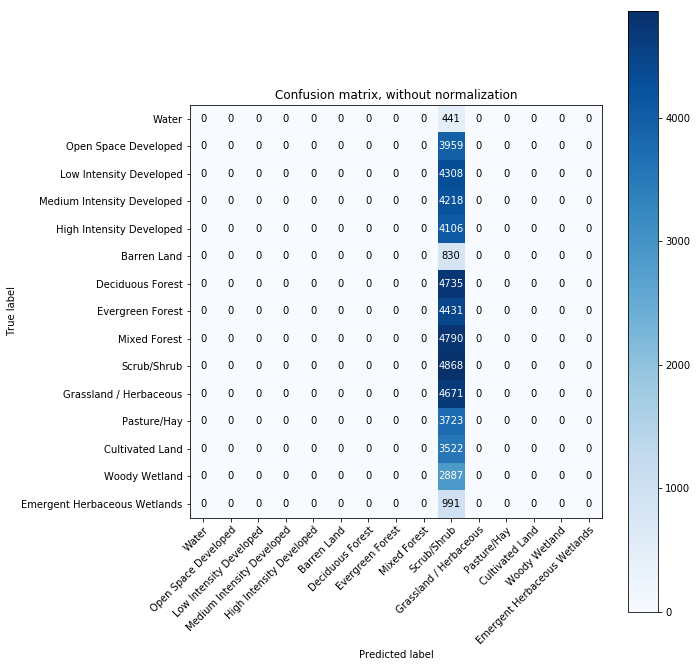

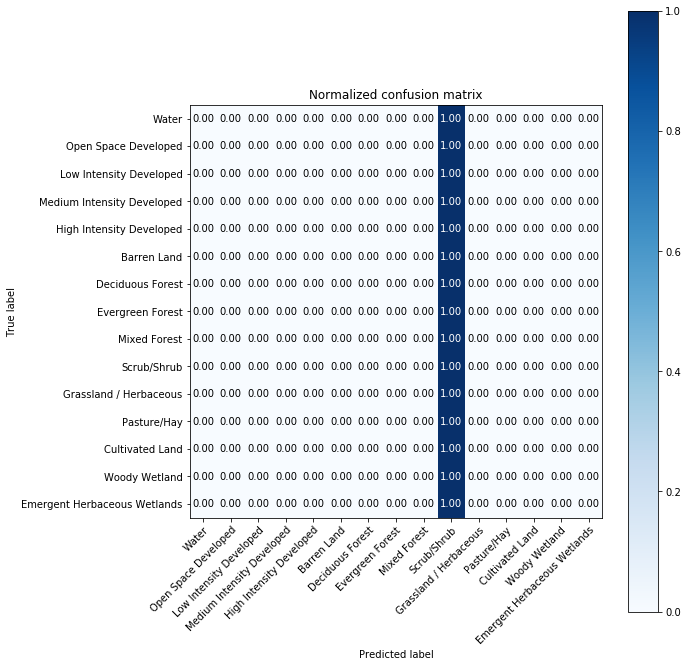

In [51]:
cu.evaluate_cnn(model, landsat_datasets[1:2], sentinel_datasets[1:2], dem_datasets[1:2], label_dataset, tile_side, train_px, old=True)

In [54]:
tile_size = tile_side
predictions = model.predict_generator(generator= nw.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_size, tile_size, pixels, batch_size), steps=len(pixels) // batch_size, verbose=1)
eval_generator = nw.tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_size, tile_size, pixels, batch_size=1)

3000/3000 [==============================] - 380s 127ms/step


In [55]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
        #print(np.argmax(label_b))
    labels[count] = label_b
    count += 1
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)
print(label_index)
print(pred_index)
    #print(pred_index)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(indexed_dictionary)),
                      class_dict=indexed_dictionary)
# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(indexed_dictionary)),
                      class_dict=indexed_dictionary,
                      normalize=True)

[13 14 13 ... 14  8  8]
[10 10 10 ... 10 10 10]


NameError: name 'plot_confusion_matrix' is not defined

In [34]:
buckets = cu.pixel_balance(train_px, landsat_datasets[1:2], label_dataset)
for i in range(len(cu.indexed_dictionary)):
    print("{}:{}".format(cu.indexed_dictionary[i], buckets[i]))

Water:596.0
Snow/Ice:0.0
Open Space Developed:3511.0
Low Intensity Developed:0.0
Medium Intensity Developed:3496.0
High Intensity Developed:0.0
Barren Land:1091.0
Deciduous Forest:3535.0
Evergreen Forest:3568.0
Mixed Forest:3471.0
Scrub/Shrub:3503.0
Grassland / Herbaceous:3501.0
Pasture/Hay:3425.0
Cultivated Land:3489.0
Woody Wetland:3517.0
Emergent Herbaceous Wetlands:1479.0
